# BLM Keyword Identification
Sandboxing some simple keyword identification routines.
Full scale work will probably not be done in a notebook, mostly exploration here.

In [1]:
from os import getcwd, listdir
import os.path
from concurrent.futures import ThreadPoolExecutor, wait
from pickle import Pickler, Unpickler

import spacy
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load("en_core_web_lg")

Gather a list of codex entries to analyze.

In [3]:
DOC_LIMIT = 500
MAX_WORKERS = None

base_path = os.path.join(getcwd(), "research/data/codex")

file_names = [f for f in listdir(base_path) if os.path.isfile(os.path.join(base_path, f)) and f.endswith(".txt")]

In [273]:
tokens = set()
for file_name in file_names:
    with open(os.path.join(base_path, file_name), 'r') as f:
        text = f.read()
    [tokens.add(token) for token in text.split()]
token_lengths = [len(token) for token in tokens]

In [367]:
max_bin = 40
hist, bins = np.histogram(token_lengths, np.arange(1, max_bin + 1))
hist_norm = hist/np.sum(hist)
hist_cum = np.cumsum(hist_norm)

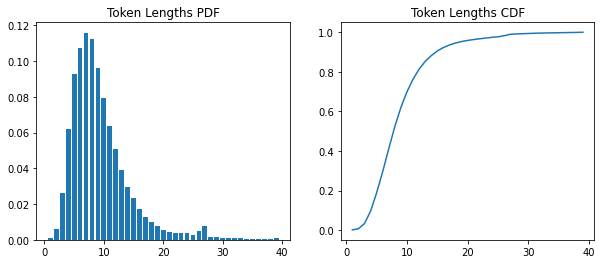

In [368]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Token Lengths PDF")
plt.bar(bins[:-1], hist_norm)

plt.subplot(122)
plt.title("Token Lengths CDF")
plt.plot(bins[:-1], hist_cum)

In [369]:
list(zip( bins[:-1], np.round(hist_cum * 100, 2)))

[(1, 0.12),
 (2, 0.7),
 (3, 3.32),
 (4, 9.53),
 (5, 18.83),
 (6, 29.55),
 (7, 41.14),
 (8, 52.35),
 (9, 61.97),
 (10, 69.89),
 (11, 76.25),
 (12, 81.35),
 (13, 85.23),
 (14, 88.17),
 (15, 90.53),
 (16, 92.26),
 (17, 93.55),
 (18, 94.55),
 (19, 95.3),
 (20, 95.86),
 (21, 96.32),
 (22, 96.69),
 (23, 97.06),
 (24, 97.42),
 (25, 97.7),
 (26, 98.21),
 (27, 98.96),
 (28, 99.11),
 (29, 99.26),
 (30, 99.38),
 (31, 99.48),
 (32, 99.56),
 (33, 99.64),
 (34, 99.69),
 (35, 99.75),
 (36, 99.81),
 (37, 99.87),
 (38, 99.91),
 (39, 100.0)]

Identifing an algorithm for named entity extraction.

In [4]:
def extract_entities(text):
    '''
    Identify entities and noun_chunks within the document,
    and filter them such that there are no overlapping spans.
    Also taking this opportunity to convert text to lower-case
    to avoid having to do this later on.
    '''
    doc = nlp(text)
    spans = spacy.util.filter_spans(
        set(doc.ents).union(set(doc.noun_chunks)))
    entities = [t.lower_ for t in [span for span in spans]]
    return entities

Identify unique entities across the corpus, and build a numeric index of each document and entity.
The document and entitity indices will be used to reference values in a sparse matrix in a later step.

In [202]:
class Opts:
    def __init__(self, init_from=None):
        if init_from:
            self.docs_m = init_from.docs_m
            self.spans_n = init_from.spans_n
            self.doc_index_m = init_from.doc_index_m
            self.span_index_n = init_from.span_index_n
        else:
            self.docs_m = dict()
            self.spans_n = dict()
            self.doc_index_m = -1
            self.span_index_n = -1
        
    def __str__(self):
        return "doc_index_m: {}, span_index_n: {}".format(self.doc_index_m, self.span_index_n)
    
    def dump(self, file_name):
        with open(file_name, 'bw') as f:
            Pickler(f).dump(self)
            
    def load(self, file_name):
        with open(file_name, 'br') as f:
            self.__init__(Unpickler(f).load())

In [189]:
opts = Opts()

def inspect_file(file_name, o):
    with open(os.path.join(base_path, file_name), 'r') as f:
        text = f.read()
    if not file_name in o.docs_m:
        o.doc_index_m = o.doc_index_m + 1
        o.docs_m[file_name] = o.doc_index_m
    entities = extract_entities(text)
    for entity in entities:
        if not entity in o.spans_n:
            o.span_index_n = o.span_index_n + 1
            o.spans_n[entity] = o.span_index_n 

In [ ]:
futures = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as e:
    for file_name in file_names[:DOC_LIMIT]:
        futures.append(e.submit(inspect_file, file_name, opts))
done, not_done = wait(futures, return_when="FIRST_EXCEPTION")
for d in done:
    if d.exception():
        [n.cancel() for n in not_done]
        raise d.exception()
print("done")

In [196]:
opts_file_name = os.path.join(os.getcwd(), "research/data/doc_entity_indices.pickle")

In [ ]:
opts = Opts(init_from=opts) # make sure we're dumping whatever is currently in the repl's memory.
opts.dump(opts_file_name)

Pass through all of the documents a second time.
This time tabulating the span (entity) frequency per document for all known entities across the corpus.

In [258]:
import random
opts = Opts()
opts.load(opts_file_name)

In [382]:
random.choices(list(opts.spans_n.items()), k=10)

[('preseason top', 6815),
 ('storm team', 50017),
 ('todd a. price a protester', 31920),
 ('that same corner', 14659),
 ('a riverside roadway', 53149),
 ('apr 7 2020hiit workout', 49344),
 ('an additional $100,000', 31231),
 ('restaurant reviews', 16482),
 ('j.', 28624),
 ('× protesters', 59765)]

unicode literals
symbols / tokens contianing symbols
specific dates / times
numbers
spans starting with articles
any span of more than 5 or so tokens
any tokens over len 30 (exclusive)
any tokens under len 4 (exclusive)

In [ ]:
M = sparse.lil_matrix((len(opts.docs_m), len(opts.spans_n)))
def analyze_corpus(file_name, matrix, o):
    doc_index = o.docs_m[file_name]
    with open(os.path.join(base_path, file_name), 'r') as f:
        text = f.read().lower()
    for span, span_index in o.spans_n.items():
        matrix[doc_index, span_index] = text.count(span)

In [ ]:
futures = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as e:
    for file_name in file_names[:DOC_LIMIT]:
        futures.append(e.submit(analyze_corpus, file_name, M, opts))
done, not_done = wait(futures, return_when="FIRST_EXCEPTION")
for d in done:
    if d.exception():
        [n.cancel() for n in not_done]
        raise d.exception()
print("done")   

In [8]:
npz_file_name = os.path.join(os.getcwd(), "research/data/corpus_entity_matrix.npz")

In [ ]:
sparse.save_npz(npz_file_name), M.tocsr())

Checking the density of the matrix for sanity.

In [111]:
def density(M):
    d = 100 * M.nnz / np.prod(M.shape)
    print("Matrix density: {}%".format(round(d,2)))

In [112]:
density(M)

Matrix density: 1.28%


Calculate tfidf values within the matrix.

In [169]:
M = sparse.load_npz(npz_file_name)

In [170]:
M.shape

(500, 63271)

In [171]:
AXIS_DOCS = 0 # rows
AXIS_ENTS = 1 # columns

In [181]:
def tfidf(M):
    tf = sparse.csr_matrix(M / M.sum(axis=AXIS_ENTS))
    N = M.shape[AXIS_DOCS]
    Nt = np.ravel(M.astype(bool).sum(axis=AXIS_DOCS))
    idf = sparse.csr_matrix(np.log10(N/Nt))
    M1 = tf.multiply(idf)
    M1.data = np.nan_to_num(M1.data)
    M1.eliminate_zeros()
    return M1

In [251]:
M_tfidf = tfidf(M)
density(M_tfidf)

means = np.ravel(M_tfidf.sum(AXIS_DOCS) / (M_tfidf != 0).sum(AXIS_DOCS))
ent_means = {k:v for (k, v) in enumerate(means)}
ents_filtered = {k:v for (k,v) in ent_means.items() if v > 0}
top_10=sorted(ents_filtered.items(), key=lambda x:x[1], reverse=True)[:10]
top_10

/Users/joe/Documents/code/rallymomentumindex/virtualenv/lib/python3.7/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


Matrix density: 1.28%


[(52176, 0.03598626672448025),
 (35753, 0.03505155849787037),
 (35754, 0.03505155849787037),
 (15819, 0.03468774700823451),
 (39247, 0.03416417727007619),
 (39248, 0.03416417727007619),
 (53273, 0.028712446854638498),
 (10233, 0.02672247529045563),
 (10235, 0.02672247529045563),
 (10236, 0.02672247529045563)]

In [252]:
list(opts.spans_n.items())[52176]

('friday night | wnwo', 52176)

Testing tfidf function using data from https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [92]:
N = sparse.csr_matrix(np.array([[1,1,2,1,0,0],
                                [1,1,0,0,2,3]]))
print(N)

  (0, 0)	1
  (0, 1)	1
  (0, 2)	2
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 4)	2
  (1, 5)	3


In [97]:
print(tfidf(N))

  (0, 3)	0.06020599913279624
  (0, 2)	0.12041199826559248
  (1, 5)	0.12901285528456335
  (1, 4)	0.08600857018970891
